# Sequential Low Rank Regression

<a target="_blank" href="https://colab.research.google.com/github/nikhil-chigali/Sequential-Low-Rank-Regression/blob/main/sequential_low_rank_regression.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [2]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds, eigs
from pprint import pprint

from utils.initializations import random_AB, orthonormal_AB
from utils.visualize import plot_all_errors
from utils.utils import log_to_csv
from utils.args import GDArgs

seed = 42
np.random.seed(seed)

## Step 0: Initialization

In [3]:
# Dimension of the matrix W (W = AB^T)
d = 100
m = 50
n = 500  # Number of samples
r = 10  # Rank of the matrix W


# Generating n input data points with d features with a normal distribution
X = np.random.randn(n, d)

# Normalizing the rows of X
X = X / la.norm(X, axis=1, keepdims=True)

# Generating Sigma, the diagonal matrix
S_star = np.geomspace(100, 1, num=r)
S_star_sqrt = np.diag(np.sqrt(S_star))

# Generating M
M = np.random.randn(d, m)
[U_star, temp, V_star] = la.svd(M)  # Performing SVD on M

# Generating A^* and B^*
A_star_hat = U_star[:, :r]  # Top-r left singular vectors
B_star_hat = V_star[:r, :].T  # Top-r right singular vectors

# Generating A* and B*
A_star = A_star_hat @ S_star_sqrt
B_star = B_star_hat @ S_star_sqrt
W_star = A_star @ B_star.T
# W_star = W_star / la.norm(W_star, 'fro')

# Noise
std = 5e-1
Z = np.random.randn(n, m)
Z = std * (1 / la.norm(Z, 'fro')) * Z

# Generating Y
Y = X @ W_star + Z

# Calculating the Lipschitz constant of H (Spectral Norm)
H = X.T @ X
[u, s, v] = svds(H, k=1)
L = s[0] # Spectral norm of H

# Setting learning rate eta
eta = 1/L

# Setting the arguments
args = GDArgs(
    d=d,
    m=m,
    n=n,
    r=r,
    eta=eta,
)

pprint(args)

GDArgs(d=100,
       r=10,
       m=50,
       n=500,
       eta=np.float64(0.09959239885293836),
       eta_A=1e-05,
       eta_B=1e-05,
       iters=1000,
       tau=20,
       epsilon=1e-08,
       lambda_orth=0.7)


In [4]:
U_star.shape, temp.shape, V_star.shape

((100, 100), (50,), (50, 50))

## Step 1.1: Implementing Simple Gradient Descent

In [7]:
def GD(X, Y, W_star, args: GDArgs):
    W_old = np.random.randn(args.d, args.m)
    i = 1

    rel_errors = []
    while i <= args.iters:
        grad = X.T @ (X @ W_old - Y)

        # print(la.matrix_rank(grad))

        W_new = W_old - args.eta * grad

        # Calculate the relative error
        rel_error = la.norm(W_new - W_star, "fro") / la.norm(W_star, "fro")
        rel_errors.append(rel_error)

        # check if the relative error between W and W* is smaller than epsilon
        if rel_error <= args.epsilon:
            print("Tolerance Error reached. Stopping the algorithm.")
            break

        W_old = W_new
        i += 1
    return W_new, rel_errors


# W_star and r are not used in the function yet

Rank of W: 50


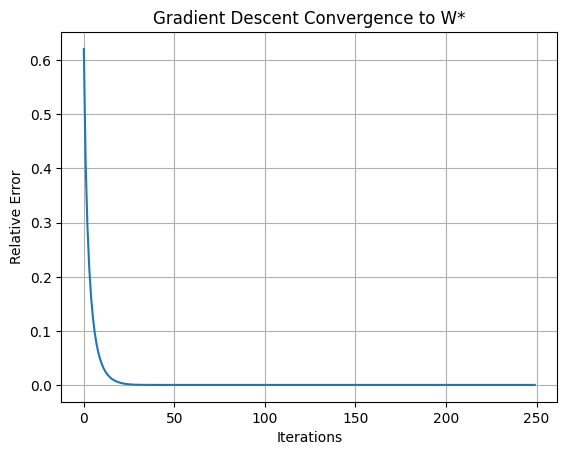

In [8]:
# Sanity check for the GD function

args.iters = 250

W, rel_errors = GD(X, Y, W_star, args)
print(f"Rank of W: {la.matrix_rank(W)}")

# Plotting the relative error
plt.plot(rel_errors)
plt.xlabel('Iterations')
plt.ylabel('Relative Error')
plt.title('Gradient Descent Convergence to W*')
plt.grid()
plt.show()


## Step 1.2: Implementing Iterative Hard-Thresholding [Projected Gradient Descent]

In [9]:
def IHT(X, Y, W_star, args: GDArgs):

    W_old = np.random.randn(args.d, args.m)
    rel_errors = []
    i = 1
    while i <= args.iters:
        grad = X.T @ (X @ W_old - Y)

        # print(la.matrix_rank(grad))

        W_mid = W_old - args.eta * grad

        # Projecting W_new to become r-rank
        U, S, V = la.svd(W_mid)
        W_new = U[:, : args.r] @ np.diag(S[: args.r]) @ V[: args.r, :]

        # Compute the relative error
        rel_error = la.norm(W_new - W_star, ord="fro") / la.norm(W_star, ord="fro")
        rel_errors.append(rel_error)

        # check if the error between W and W* is smaller than the epsilon
        if rel_error <= args.epsilon:
            print("Tolerance Error reached. Stopping the algorithm.")
            break

        W_old = W_new
        i += 1
    return W_new, rel_errors


# W_star is not used in the function yet

Rank of W_IHT: 10


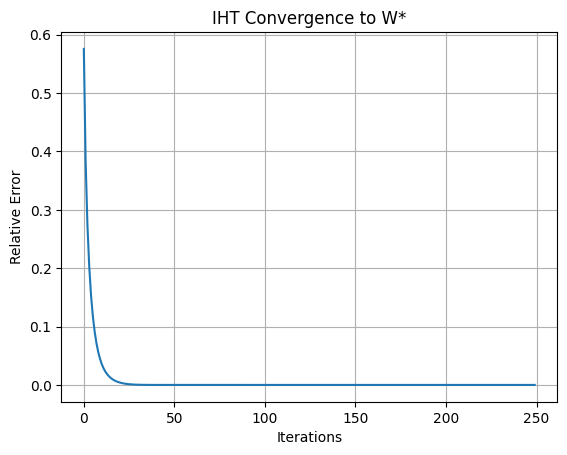

In [10]:
# Sanity check for the IHT function
W_IHT, rel_errors = IHT(X, Y, W_star, args)

print(f"Rank of W_IHT: {la.matrix_rank(W_IHT)}")

# Plotting the relative error
plt.plot(rel_errors)
plt.xlabel('Iterations')
plt.ylabel('Relative Error')
plt.title('IHT Convergence to W*')
plt.grid()
plt.show()

In [11]:
print(f"Distance between W and W_star: {la.norm(W - W_star, ord='fro')}")
print(f"Distance between W_IHT and W_star: {la.norm(W_IHT - W_star, ord='fro')}\n")

print(f"Relative Error of W: {la.norm(W - W_star, ord='fro') / la.norm(W_star, ord='fro')}")
print(f"Relative Error of W_IHT: {la.norm(W_IHT - W_star, ord='fro') / la.norm(W_star, ord='fro')}\n")

Distance between W and W_star: 0.11313694070533711
Distance between W_IHT and W_star: 0.05824359689529316

Relative Error of W: 0.0009055491314748458
Relative Error of W_IHT: 0.0004661822942505611



### Step 1.2.1: Comparing rank-1 IHT approximations of `W*` with that of the actual `W*`  

In [12]:
# Initializing iters and epsilon

args_seq = GDArgs(
        d=d,
        m=m,
        n=n,
        r=1,
        eta=eta, 
        iters=1000, 
        epsilon=1e-16
    )

W_r1_components = np.zeros((args.r, d, m))

Y_res = Y.copy()

# Computing the SVD of W_star
U, S, V = la.svd(W_star, full_matrices=False)
print(f"Left Singular Matrix `U`: {U.shape}")
print(f"Singular Values `S`: {S.shape}")
print(f"Right Singular Matrix `V`: {V.shape}\n")

# Initializing the sum of the r-rank components
W_IHT_sum = np.zeros_like(W_star)
W_SVD_sum = np.zeros_like(W_star)

# Relative error between the IHT and SVD components
rank = 10
rel_error_IHT_SVD = np.zeros(rank)

for i in range(rank):
    ## IHT + Deflation
    # IHT
    W_IHT, errors = IHT(X, Y_res, W_star, args_seq)
    # Storing the r-rank components
    W_r1_components[i] = W_IHT

    # Adding the r-rank component to the sum
    W_IHT_sum += W_IHT

    # Deflation
    Y_res = Y_res - X @ W_IHT

    ## SVD
    W_SVD = S[i] * np.outer(U[:, i], V[i, :])

    # Adding the r-rank component to the sum
    W_SVD_sum += W_SVD

    # Computing the relative error between the IHT and SVD components
    rel_error_IHT_SVD[i] = la.norm(W_IHT - W_SVD, ord="fro") / la.norm(W_SVD, ord="fro")
    print(
        f"Rank {i+1:02d} - Sigma_{i+1:02d}: {S[i]:.05f} | Relative Error (IHT, SVD): {rel_error_IHT_SVD[i]}"
    )

# Rank-r cumulative error
print(
    "Relative error (W_IHT_sum, W_SVD_sum): ",
    la.norm(W_IHT_sum - W_SVD_sum, ord="fro") / la.norm(W_SVD_sum, ord="fro"),
)

Left Singular Matrix `U`: (100, 50)
Singular Values `S`: (50,)
Right Singular Matrix `V`: (50, 50)

Rank 01 - Sigma_01: 100.00000 | Relative Error (IHT, SVD): 0.03511196524167549
Rank 02 - Sigma_02: 59.94843 | Relative Error (IHT, SVD): 0.059297829891153835
Rank 03 - Sigma_03: 35.93814 | Relative Error (IHT, SVD): 0.07128211620903967
Rank 04 - Sigma_04: 21.54435 | Relative Error (IHT, SVD): 0.1247266855742046
Rank 05 - Sigma_05: 12.91550 | Relative Error (IHT, SVD): 0.04143567044367552
Rank 06 - Sigma_06: 7.74264 | Relative Error (IHT, SVD): 0.12719293382355634
Rank 07 - Sigma_07: 4.64159 | Relative Error (IHT, SVD): 0.13834407854948902
Rank 08 - Sigma_08: 2.78256 | Relative Error (IHT, SVD): 0.13512389028487073
Rank 09 - Sigma_09: 1.66810 | Relative Error (IHT, SVD): 0.11725643672080774
Rank 10 - Sigma_10: 1.00000 | Relative Error (IHT, SVD): 0.1075878606466269
Relative error (W_IHT_sum, W_SVD_sum):  0.00046618229425052324


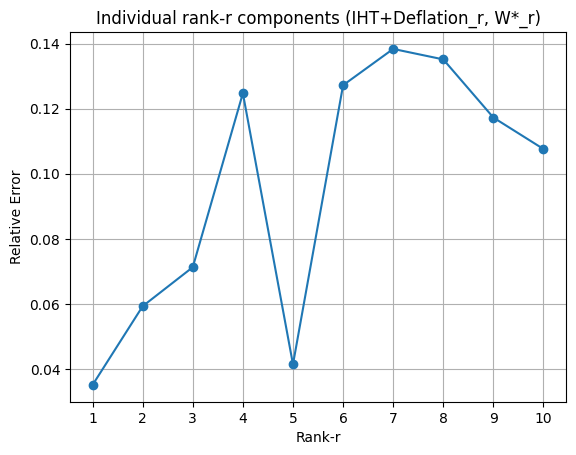

In [14]:
# Plotting the relative error between the IHT and SVD components
plt.plot(range(1, rank+1), rel_error_IHT_SVD, marker='o')
plt.xticks(range(1, rank+1))
plt.xlabel("Rank-r")
plt.ylabel("Relative Error")
plt.title("Individual rank-r components (IHT+Deflation_r, W*_r)")
plt.grid()
plt.show()


Rank 01 - Relative Error: 0.5998059205520019
Rank 02 - Relative Error: 0.35954450254901127
Rank 03 - Relative Error: 0.21607000105330568
Rank 04 - Relative Error: 0.12930929302064054
Rank 05 - Relative Error: 0.07764054731666492
Rank 06 - Relative Error: 0.04629144278304898
Rank 07 - Relative Error: 0.0273319558919271
Rank 08 - Relative Error: 0.015656892362831396
Rank 09 - Relative Error: 0.00805286148241625
Rank 10 - Relative Error: 0.0004661822942505727


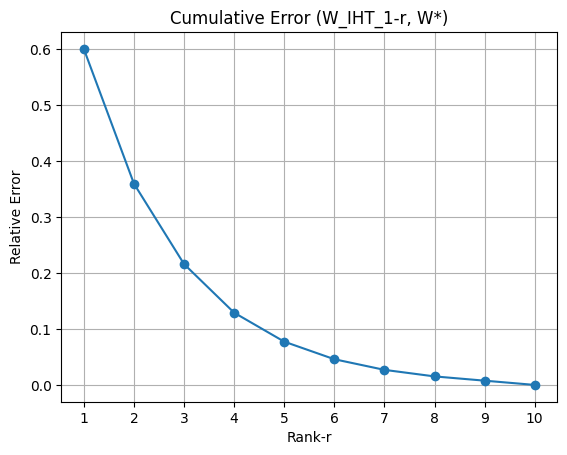

In [16]:
# Cumulative error of rank-r approximation using IHT+Deflation method
W_r_errors = np.zeros(rank)

for i in range(rank):
    W_r = np.sum(W_r1_components[:i+1], axis=0)
    W_r_errors[i] = la.norm(W_r - W_star, ord='fro') / la.norm(W_star, ord='fro')
    print(f"Rank {i+1:02d} - Relative Error: {W_r_errors[i]}")
    
# Plotting the Cumulative error of rank-r approximation
plt.plot(range(1, rank+1), W_r_errors, marker='o')
plt.xticks(range(1, rank+1))
plt.xlabel("Rank-r")
plt.ylabel("Relative Error")
plt.title("Cumulative Error (W_IHT_1-r, W*)")
plt.grid()

plt.show()

Rank 01 - Relative Error: 0.03511196524167549
Rank 02 - Relative Error: 0.014531086081407497
Rank 03 - Relative Error: 0.023167070139462554
Rank 04 - Relative Error: 0.009226784097931883
Rank 05 - Relative Error: 0.00857666806299636
Rank 06 - Relative Error: 0.005387651176487502
Rank 07 - Relative Error: 0.0033805015024249816
Rank 08 - Relative Error: 0.0017330995113591858
Rank 09 - Relative Error: 0.0009431304650410679
Rank 10 - Relative Error: 0.00046618229425052324


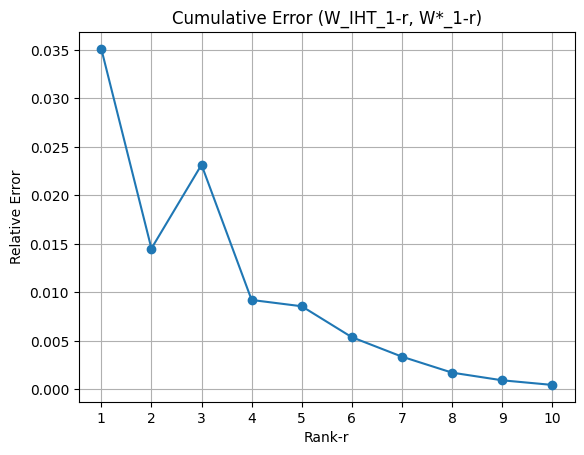

In [17]:
# Cumulative error of rank-r approximation using IHT+Deflation method
W_r_errors = np.zeros(rank)

for i in range(rank):
    W_r = np.sum(W_r1_components[:i+1], axis=0)
    W_star_i = np.sum([S[j] * np.outer(U[:, j], V[j, :]) for j in range(i+1)], axis=0)
    W_r_errors[i] = la.norm(W_r - W_star_i, ord='fro') / la.norm(W_star_i, ord='fro')
    print(f"Rank {i+1:02d} - Relative Error: {W_r_errors[i]}")
    
# Plotting the Cumulative error of rank-r approximation
plt.plot(range(1, rank+1), W_r_errors, marker='o')
plt.xticks(range(1, rank+1))
plt.xlabel("Rank-r")
plt.ylabel("Relative Error")
plt.title("Cumulative Error (W_IHT_1-r, W*_1-r)")
plt.grid()

plt.show()

## Step 2.1: Implementing Factorized GD

In [5]:
# Defining the loss function

def MSE_loss_factorized(X, Y, A, B, grad=False):
    # Depends on the data X and Y
    if grad:
        grad_A = X.T @ (X @ (A @ B.T) - Y) @ B
        grad_B = (X @ (A @ B.T) - Y).T @ X @ A
        
        # Normalizing the gradients
        # grad_A = grad_A / la.norm(grad_A, ord="fro")
        # grad_B = grad_B / la.norm(grad_B, ord="fro")
        
        return grad_A, grad_B
    return 0.5 * la.norm(Y - X @ (A @ B.T), ord="fro") ** 2

# Gradient Descent Update Rule
def MSE_GD_Update(X, Y, A_old, B_old, eta_A, eta_B):
    """
    Update the factorized matrices A and B using the gradient descent update rule
    """
    grad_A, grad_B = MSE_loss_factorized(X, Y, A_old, B_old, grad=True)
    A_new = A_old - eta_A * grad_A
    B_new = B_old - eta_B * grad_B
    return A_new, B_new

In [6]:
def FactorizedGD(X, Y, A_0, B_0, W_star, args: GDArgs):
    # Initialization of A and B
    A_new = A_0
    B_new = B_0

    # Tracking errors and relative errors
    errors = {"mse": [], "rel_error_W": []}

    i = 1
    while i <= args.iters:
        A_old = A_new
        B_old = B_new

        # Compute the gradient of A and B        
        grad_A, grad_B = MSE_loss_factorized(X, Y, A_old, B_old, grad=True)

        # Update A and B
        A_new, B_new = MSE_GD_Update(X, Y, A_old, B_old, args.eta_A, args.eta_B)

        # Tracking errors and relative errors
        errors["mse"].append(MSE_loss_factorized(X, Y, A_new, B_new))

        # Relative error between the (A, B) and W* components
        W_new = A_new @ B_new.T
        rel_error_W = la.norm(W_new - W_star, ord="fro") / la.norm(W_star, ord="fro")
        errors["rel_error_W"].append(rel_error_W.item())

        # check if the relative error in A, B and A*, B* is smaller than epsilon
        if rel_error_W <= args.epsilon:
            print("Convergence reached. Stopping the algorithm.")
            break

        i += 1

    return A_new, B_new, errors

In [10]:
# Factorized Gradient Descent log file
filename = "results/MatrixFactorization_GD.csv"

# Setting the arguments
args = GDArgs(
    d=d,
    m=m,
    n=n,
    r=r,
    eta=1/L,
    eta_A=1e-3,
    eta_B=1e-3,
    iters=500,
    epsilon=1e-6
)

# Initializing A and B
A_0, B_0 = {}, {}
A_0["random"], B_0["random"] = random_AB(args)
A_0["orthonormal"], B_0["orthonormal"] = orthonormal_AB(args)

In [16]:
## Random Initialization
errors = {
    "orth_A": [],
    "orth_B": [],
    "mse": [],
    "rel_error_W": []
}


# Calculating the loss and relative errors for A_0 and B_0
orth_A, orth_B = Orthogonal_loss_factorized(A_0["random"], B_0["random"])
mse = MSE_loss_factorized(X, Y, A_0["random"], B_0["random"])
rel_error_W = la.norm(A_0["random"] @ B_0["random"].T - W_star, ord="fro") / la.norm(W_star, ord="fro")

errors["mse"].append(mse)
errors["orth_A"].append(orth_A)
errors["orth_B"].append(orth_B)
errors["rel_error_W"].append(rel_error_W)

# Logging the initial loss and relative errors
log_to_csv(filename, "InitialError-RandomInit_r10", errors, args)

###################################################################################

## Orthonormal Initialization
errors = {
    "orth_A": [],
    "orth_B": [],
    "mse": [],
    "rel_error_W": []
}

# Calculating the loss and relative errors for A_0 and B_0
orth_A, orth_B = Orthogonal_loss_factorized(A_0["orthonormal"], B_0["orthonormal"])
mse = MSE_loss_factorized(X, Y, A_0["orthonormal"], B_0["orthonormal"])
rel_error_W = la.norm(A_0["orthonormal"] @ B_0["orthonormal"].T - W_star, ord="fro") / la.norm(W_star, ord="fro")

errors["mse"].append(mse)
errors["orth_A"].append(orth_A)
errors["orth_B"].append(orth_B)
errors["rel_error_W"].append(rel_error_W)

# Logging the initial loss and relative errors
log_to_csv(filename, "InitialError-OrthInit_r10", errors, args)

Experiment: InitialError-RandomInit_r10
Learning Rate A: 0.001
Learning Rate B: 0.001
Orthogonalization Steps per Iteration: 20
Relative Error of (W, W*): 1.0002300920559681
MSE Loss: 40176.43764099402
Orthogonal Constraint Loss A: 0.35404279162595825
Orthogonal Constraint Loss B: 0.9111506285639005
Experiment: InitialError-OrthInit_r10
Learning Rate A: 0.001
Learning Rate B: 0.001
Orthogonalization Steps per Iteration: 20
Relative Error of (W, W*): 1.0008368155271021
MSE Loss: 40203.23612819997
Orthogonal Constraint Loss A: 7.022127089606286e-32
Orthogonal Constraint Loss B: 1.3635067748360135e-31


Experiment: FactorizedGD-RandomInit_r10
Learning Rate A: 0.001
Learning Rate B: 0.001
Orthogonalization Steps per Iteration: NAN
Relative Error of (W, W*): 0.01026529790196303
MSE Loss: 3.4042537580578007
Orthogonal Constraint Loss A: NAN
Orthogonal Constraint Loss B: NAN


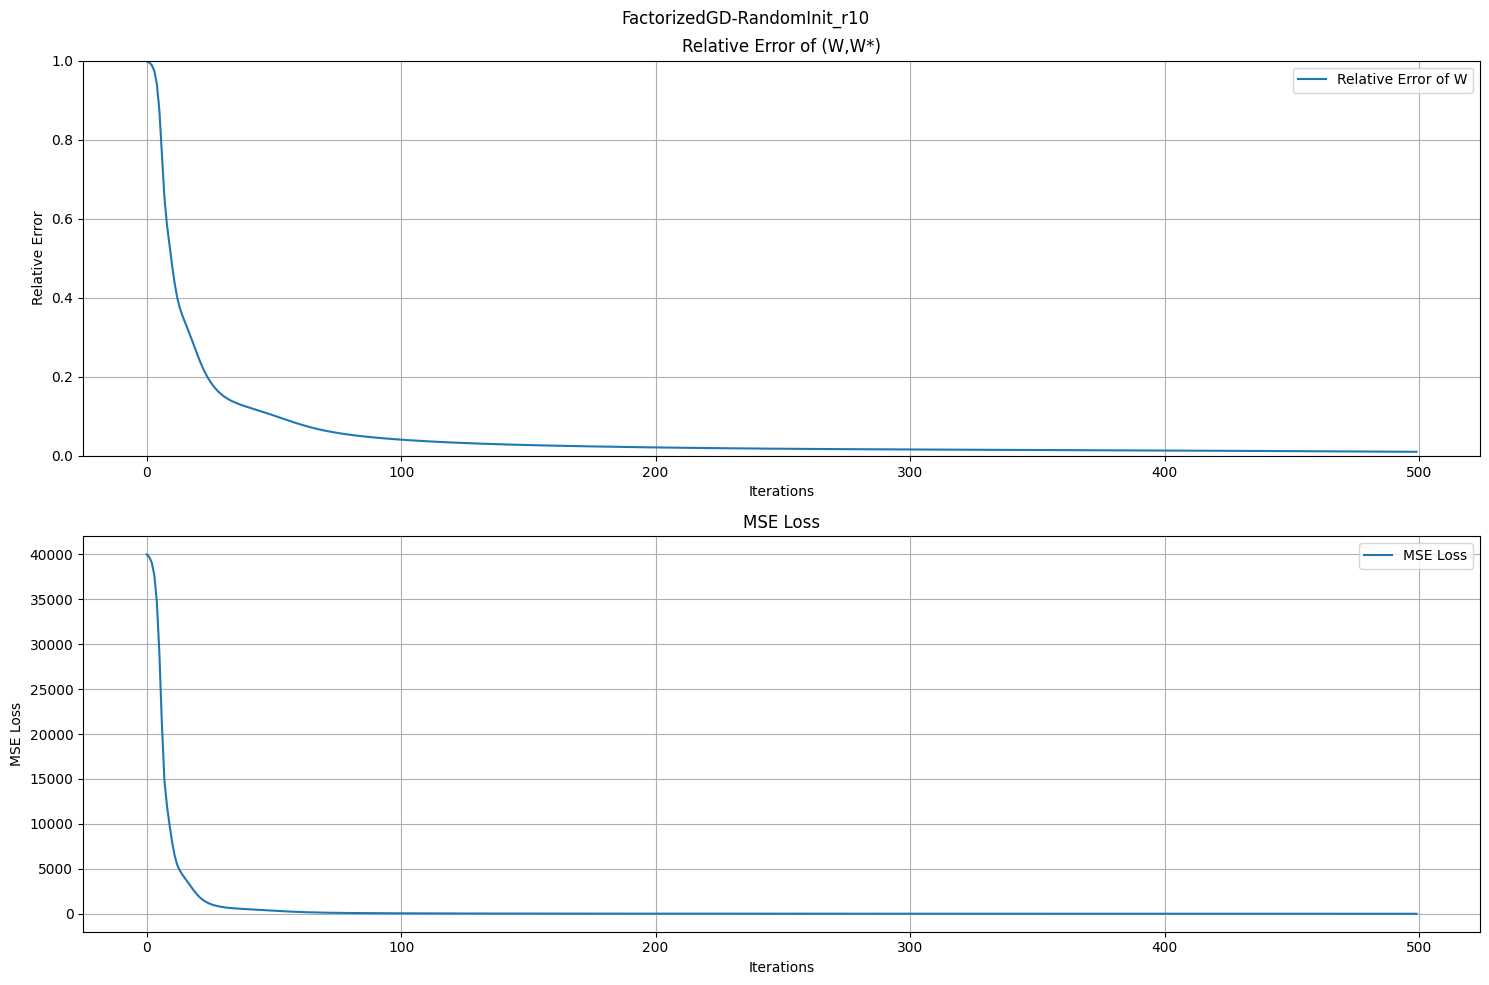

In [11]:
exp_name = "FactorizedGD-RandomInit_r10"

# Initialization of A and B: Random Initialization
A_new, B_new, errors = FactorizedGD(X, Y, A_0["random"], B_0["random"], W_star, args)

# Logging the results
log_to_csv(filename, exp_name, errors, args)

# Plotting the errors
plot_all_errors(exp_name, errors)

Experiment: FactorizedGD-OrthonormalInit_r10
Learning Rate A: 0.001
Learning Rate B: 0.001
Orthogonalization Steps per Iteration: NAN
Relative Error of (W, W*): 0.008104812091040518
MSE Loss: 1.9833520134403755
Orthogonal Constraint Loss A: NAN
Orthogonal Constraint Loss B: NAN


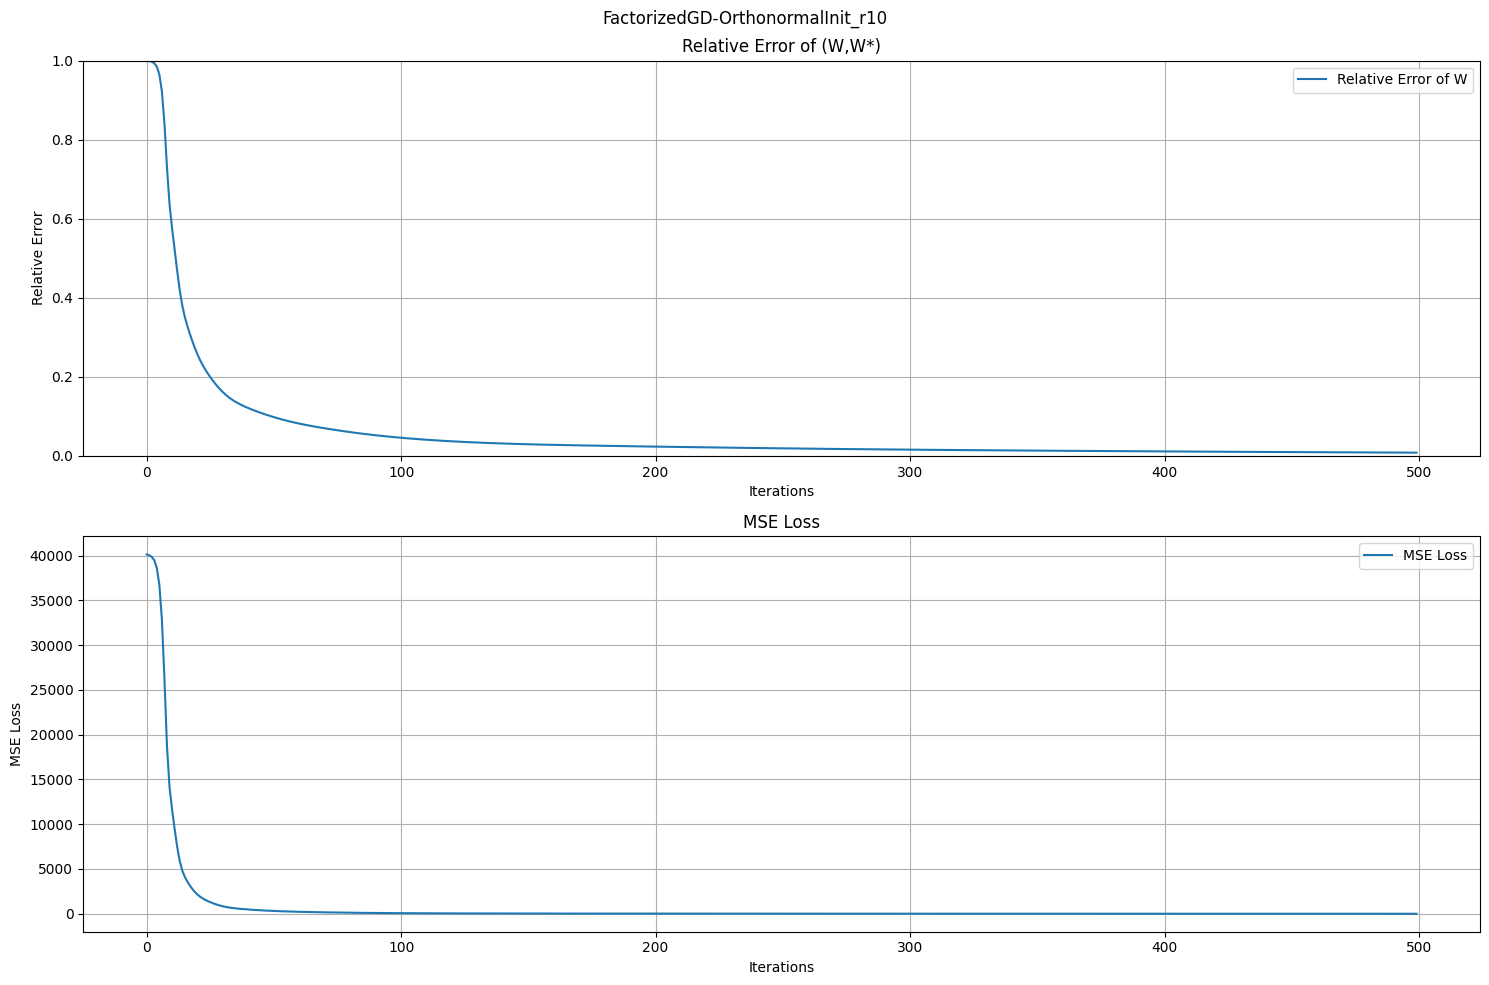

In [12]:
exp_name = "FactorizedGD-OrthonormalInit_r10"

# Initialization of A and B: Orthonormal Initialization
A_new, B_new, errors = FactorizedGD(X, Y, A_0["orthonormal"], B_0["orthonormal"], W_star, args)

# Logging the results
log_to_csv(filename, exp_name, errors, args)

# Plotting the errors
plot_all_errors(exp_name, errors)

## Step 2.2: Factorized GD with Iterative Orthogonalization

### Step 2.2.1: GD with an additional Orthogonalization loss
We will optimize the MSE loss in addition to Orthogonalization losses. The intention is to have `A` & `B` as orthogonal matrices.

**Loss function**
> $\mathbb{L} = \frac{1}{2} \|Y - AB \cdot X\|_{F}^{2}$

**Orthogonality Loss** 
> $\mathbb{O}_A = \frac{1}{2} \| A^TA - I \odot A^TA \|_F^2$ \
> $\mathbb{O}_B = \frac{1}{2} \| B^TB - I \odot B^TB \|_F^2$ \
> Where, $A \odot B$ represents the Hadamard Product between `A` and `B`

Note that the Orthogonality constraint is not dependant on the data `X`, `Y`. We will run an additional GD update loop with the Orthogonality loss's gradient $\tau$ times every iteration.

In [19]:
# Defining Orthogonalization Loss and Gradients for Factorized GD 
def Orthogonal_loss_factorized(A, B, grad=False):
    # Doesn't depend on the data X and Y
    gram_A = A.T @ A
    gram_B = B.T @ B
    if grad:
        grad_A = 2 * A @ (gram_A - np.eye(gram_A.shape[0]) * gram_A)
        grad_B = 2 * B @ (gram_B - np.eye(gram_B.shape[0]) * gram_B)
        
        # Normalizing the gradients
        # grad_A = grad_A / la.norm(grad_A, ord="fro")
        # grad_B = grad_B / la.norm(grad_B, ord="fro")
        
        return grad_A, grad_B
    orth_A = 0.5 * la.norm(gram_A - np.eye(gram_A.shape[0]) * gram_A, ord="fro") ** 2
    orth_B = 0.5 * la.norm(gram_B - np.eye(gram_B.shape[0]) * gram_B, ord="fro") ** 2
    return orth_A, orth_B

# Orthogonal Gradient Descent Update Rule
def Orth_GD_Update(A_old, B_old, eta_A, eta_B):
    """
    Update the factorized matrices A and B using the gradient descent update rule
    """
    grad_A_orth, grad_B_orth = Orthogonal_loss_factorized(A_old, B_old, grad=True)
    A_new = A_old - eta_A * grad_A_orth
    B_new = B_old - eta_B * grad_B_orth
    return A_new, B_new


In [23]:
def FactorizedGD_Orth(X, Y, A_0, B_0, W_star, args: GDArgs):

    # Initialization of A and B
    A_new, B_new = A_0, B_0


    # Error and relative error
    errors = {"rel_error_W": [], "orth_A": [], "orth_B": [], "mse": []}

    i = 1
    while i <= args.iters:
        A_old = A_new
        B_old = B_new

        # MSE update on A and B
        A_new, B_new = MSE_GD_Update(X, Y, A_old, B_old, args.eta_A, args.eta_B)

        # Orthogonal update on A and B
        for t in range(args.tau):
            A_new, B_new = Orth_GD_Update(A_new, B_new, args.eta_A, args.eta_B)


        # Compute the error
        orth_A, orth_B = Orthogonal_loss_factorized(A_new, B_new)
        mse = MSE_loss_factorized(X, Y, A_new, B_new)


        # Relative error between the (A, B) and (A*, B*) components
        errors["orth_A"].append(orth_A)
        errors["orth_B"].append(orth_B)
        errors["mse"].append(mse)


        # Compute relative error between W and W*
        W_new = A_new @ B_new.T
        rel_error_W = la.norm(W_new - W_star, ord="fro") / la.norm(W_star, ord="fro")
        errors["rel_error_W"].append(rel_error_W)

        # check if the relative error in A, B and A*, B* is smaller than epsilon

        if rel_error_W <= args.epsilon:
            print("Convergence reached. Stopping the algorithm.")
            break

        i += 1


    return A_new, B_new, errors

In [25]:
args.tau = 100

pprint(args)

GDArgs(d=100,
       r=10,
       m=50,
       n=500,
       eta=np.float64(0.09959239885293836),
       eta_A=0.001,
       eta_B=0.001,
       iters=500,
       tau=100,
       epsilon=1e-06,
       lambda_orth=0.7)


Experiment: FactorizedOrthGD-RandInit_r10
Learning Rate A: 0.001
Learning Rate B: 0.001
Orthogonalization Steps per Iteration: 100
Relative Error of (W, W*): 0.019500451329719844
MSE Loss: 9.486862714964442
Orthogonal Constraint Loss A: 4.272739779443387e-05
Orthogonal Constraint Loss B: 6.323849766158138e-05


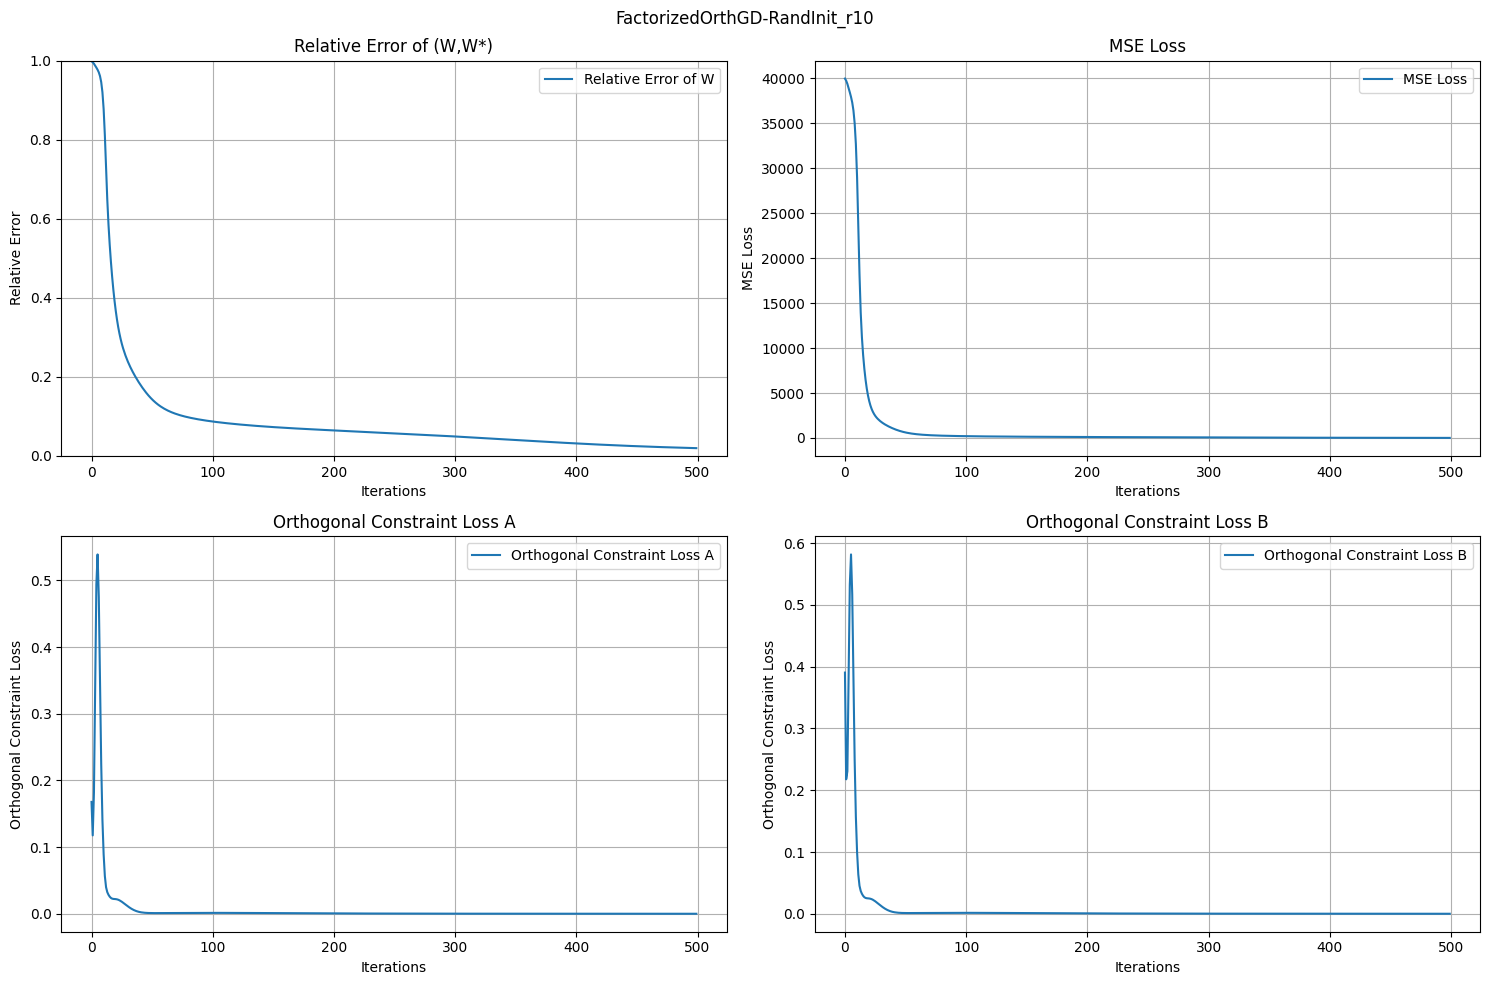

In [26]:
exp_name = "FactorizedOrthGD-RandInit_r10"

A_new, B_new, errors = FactorizedGD_Orth(
    X, Y, A_0["random"], B_0["random"], W_star, args
)

# Logging the final loss and relative errors
log_to_csv(filename, exp_name, errors, args)

# Plotting the errors
plot_all_errors(exp_name, errors)

Experiment: FactorizedOrthGD-OrthonormalInit_r10
Learning Rate A: 0.001
Learning Rate B: 0.001
Orthogonalization Steps per Iteration: 100
Relative Error of (W, W*): 0.017355030060276614
MSE Loss: 6.935622951914073
Orthogonal Constraint Loss A: 0.00010292900664729174
Orthogonal Constraint Loss B: 0.00010706758892712283


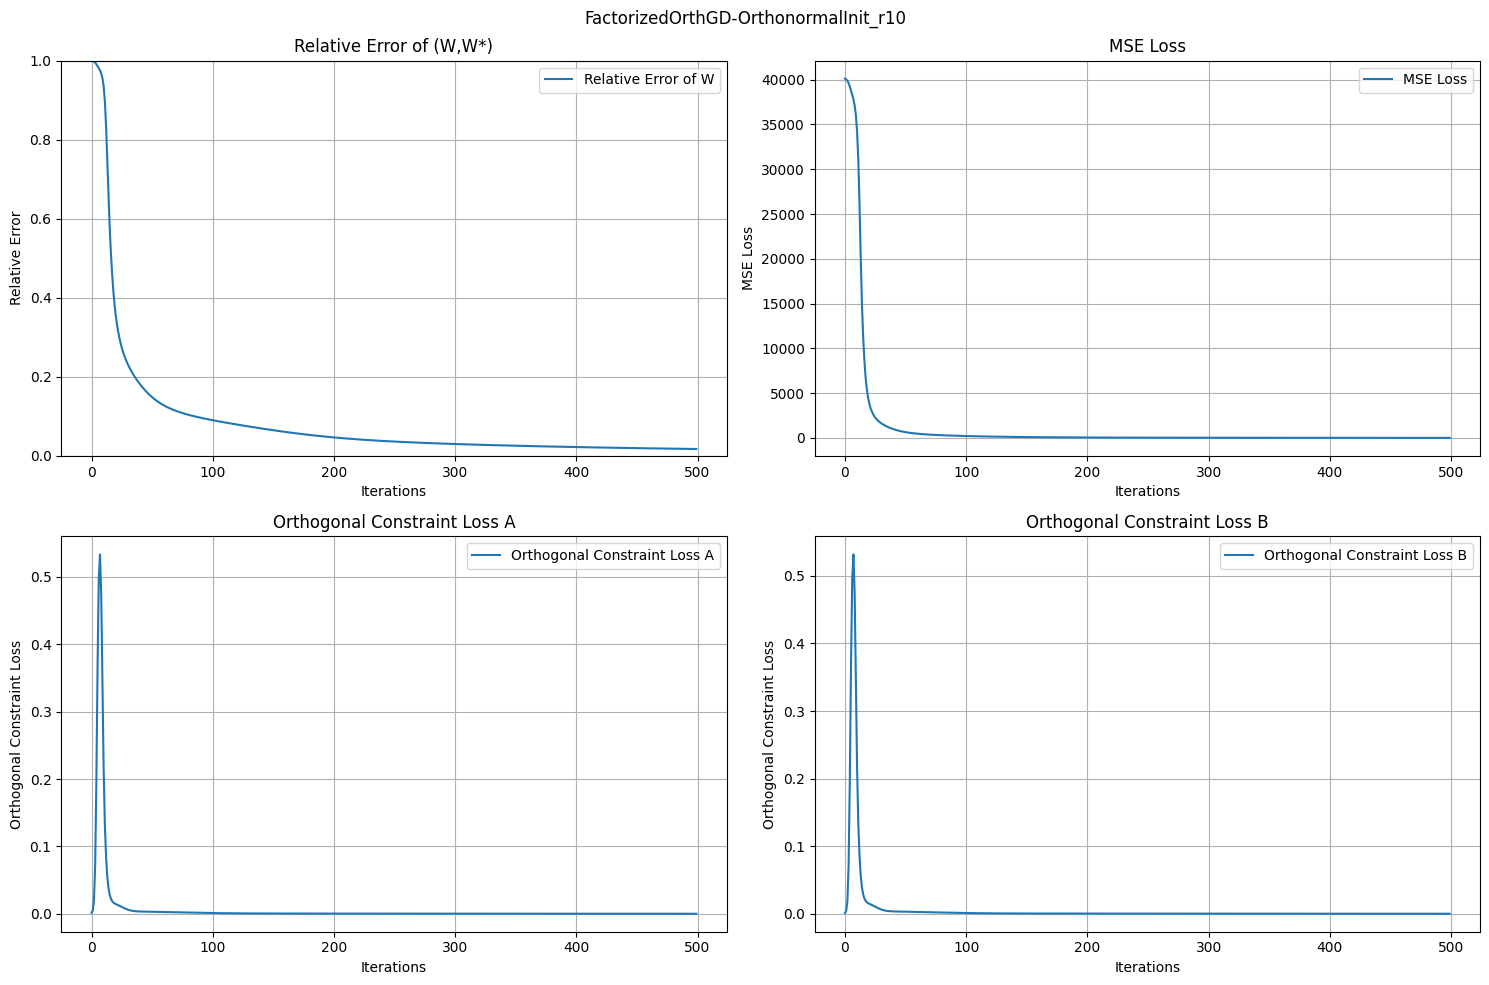

In [27]:
exp_name = "FactorizedOrthGD-OrthonormalInit_r10"

A_new, B_new, errors = FactorizedGD_Orth(
    X, Y, A_0["orthonormal"], B_0["orthonormal"], W_star, args
)

# Logging the final loss and relative errors
log_to_csv(filename, exp_name, errors, args)

# Plotting the errors
plot_all_errors(exp_name, errors)

Experiment: FactorizedOrthGD-RandInit_r10
Learning Rate A: 0.001
Learning Rate B: 0.001
Orthogonalization Steps per Iteration: 250
Relative Error of (W, W*): 0.017038670046067045
MSE Loss: 7.149490116758919
Orthogonal Constraint Loss A: 1.9187134370524312e-06
Orthogonal Constraint Loss B: 2.9468587028223237e-06


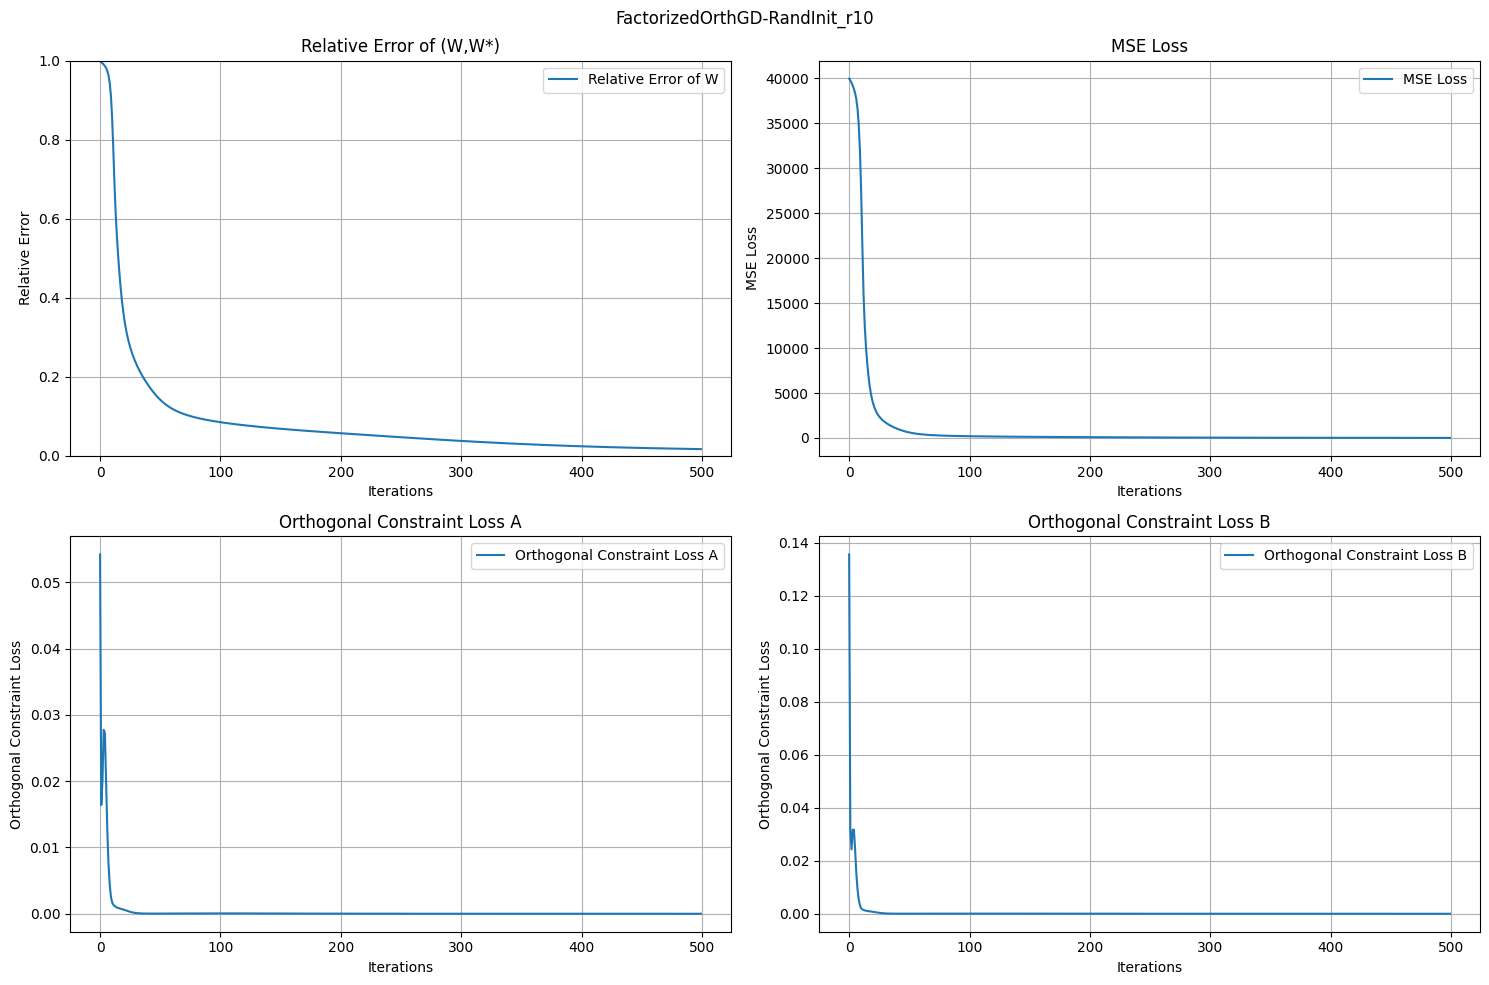

In [28]:
exp_name = "FactorizedOrthGD-RandInit_r10"
args.tau = 250

A_new, B_new, errors = FactorizedGD_Orth(
    X, Y, A_0["random"], B_0["random"], W_star, args
)

# Logging the final loss and relative errors
log_to_csv(filename, exp_name, errors, args)

# Plotting the errors
plot_all_errors(exp_name, errors)

Experiment: FactorizedOrthGD-OrthonormalInit_r10
Learning Rate A: 0.001
Learning Rate B: 0.001
Orthogonalization Steps per Iteration: 250
Relative Error of (W, W*): 0.0173219586645421
MSE Loss: 6.909825821887628
Orthogonal Constraint Loss A: 3.966730398709841e-06
Orthogonal Constraint Loss B: 4.166014240037071e-06


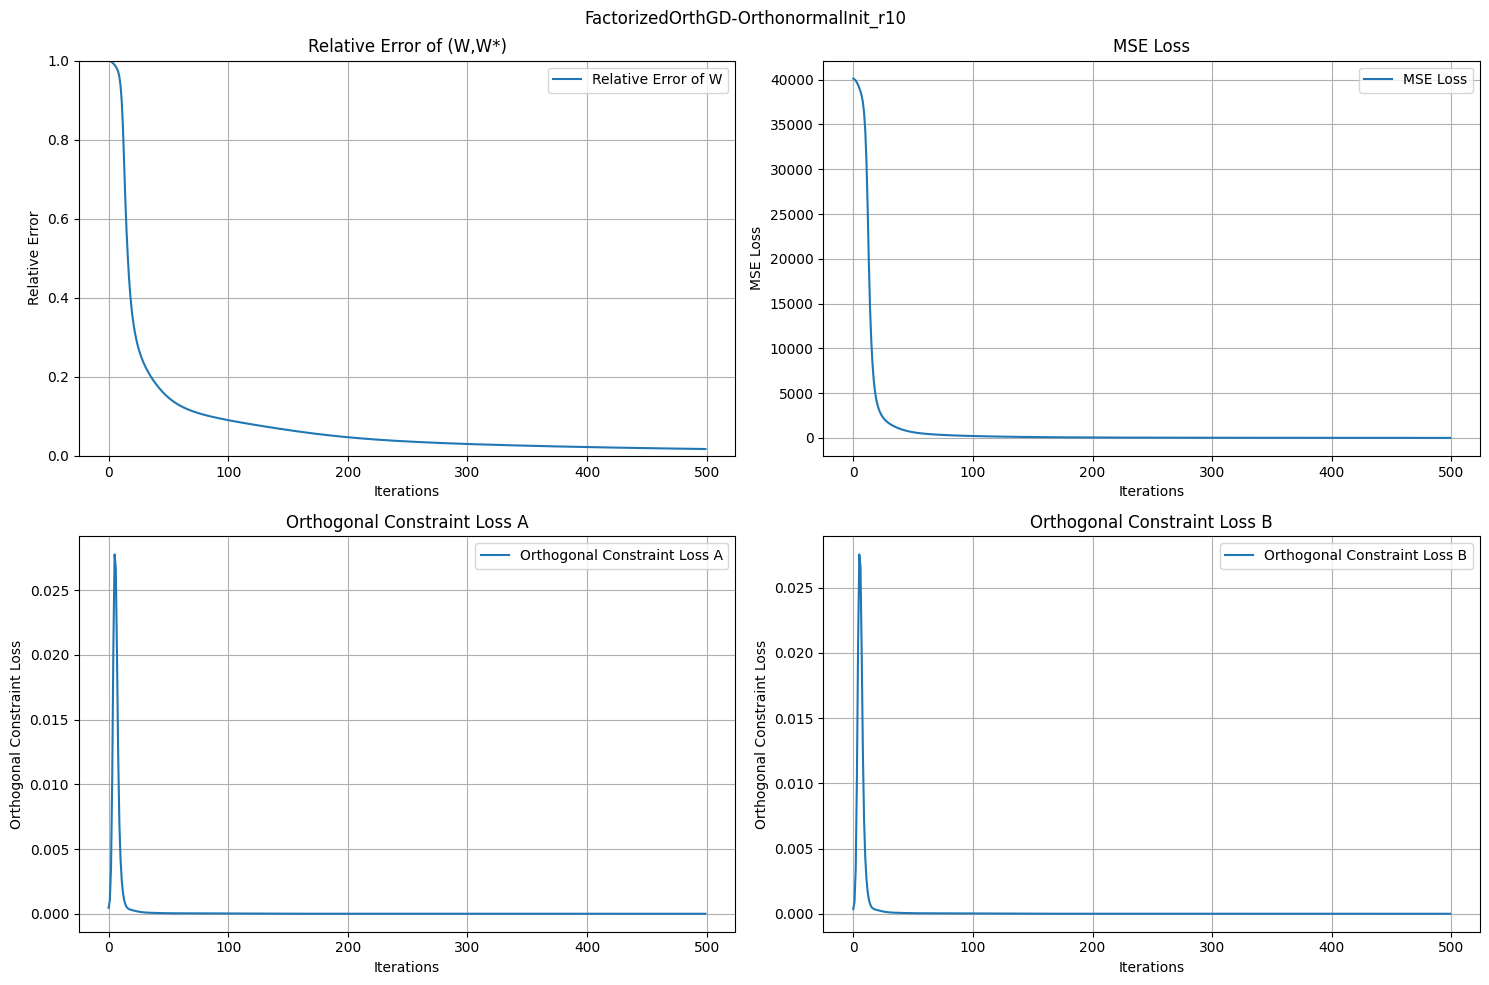

In [29]:
exp_name = "FactorizedOrthGD-OrthonormalInit_r10"
args.tau = 250

A_new, B_new, errors = FactorizedGD_Orth(
    X, Y, A_0["orthonormal"], B_0["orthonormal"], W_star, args
)

# Logging the final loss and relative errors
log_to_csv(filename, exp_name, errors, args)

# Plotting the errors
plot_all_errors(exp_name, errors)

| **Experiment**                         | **LearningRate_A** | **LearningRate_B** | **Orth_steps_per_iter** | **Rel_Error_W** | **MSE_loss** | **Orth_loss_A** | **Orth_loss_B** |
|----------------------------------------|---------------------|---------------------|-------------------------|------------------|--------------|------------------|------------------|
| InitialError-RandomInit_r10           | 0.001               | 0.001               | 20                      | 1.0002           | 40176.44     | 0.3540           | 0.9112           |
| InitialError-OrthInit_r10             | 0.001               | 0.001               | 20                      | 1.0008           | 40203.24     | 7.0221e-32       | 1.3635e-31       |
| FactorizedGD-RandomInit_r10           | 0.001               | 0.001               | NAN                     | 0.0103           | 3.4043       | NAN              | NAN              |
| FactorizedGD-OrthonormalInit_r10      | 0.001               | 0.001               | NAN                     | 0.0081           | 1.9834       | NAN              | NAN              |
| FactorizedOrthGD-RandInit_r10         | 0.001               | 0.001               | 100                     | 0.0195           | 9.4869       | 4.2727e-05       | 6.3238e-05       |
| FactorizedOrthGD-OrthonormalInit_r10  | 0.001               | 0.001               | 100                     | 0.0174           | 6.9356       | 1.0293e-04       | 1.0707e-04       |
| FactorizedOrthGD-RandInit_r10         | 0.001               | 0.001               | 250                     | 0.0170           | 7.1495       | 1.9187e-06       | 2.9469e-06       |
| FactorizedOrthGD-OrthonormalInit_r10  | 0.001               | 0.001               | 250                     | 0.0173           | 6.9098       | 3.9667e-06       | 4.1660e-06       |

**Observations**
- Orthonormal initialization performs better than Random Initialization of `(A, B)`
- Better MSE and relative errors are observed without the orthogonalization constraint.


Results can be viewed under [results/MatrixFactorization_GD.csv](https://github.com/nikhil-chigali/Sequential-Low-Rank-Regression/blob/main/results/MatrixFactorization_GD.csv)

## Step 2.3: Sequential recovery of rank-1 components in A, B

### Step 2.3.1: Sequential Factorized GD without Orthogonalization

In [109]:
# log file
filename = "results/SequentialFactorized_GD.csv"

# Setting the arguments for the sequential factorized GD
seq_args = GDArgs(
    d=d,
    m=m,
    n=n,
    r=1,
    eta=1/L,
    eta_A=1e-3,
    eta_B=1e-3,
    iters=500,
    epsilon=1e-6,
    tau=0
)

In [110]:
# Sequential recovery of rank-1 components
A_0, B_0 = random_AB(seq_args)

# Rank-1 components
A_r1s = np.zeros((args.r, d, seq_args.r))
B_r1s = np.zeros((args.r, m, seq_args.r))

# Errors
seq_errors = []

# Sequential Factorized Gradient Descent
filename = "results/SequentialFactorized_GD.csv"
exp_name = "SequentialFactorizedGD_r1"

Y_res = Y.copy()

# Running the sequential factorized GD with random initialization
for i in range(args.r):
    print(f"\n ------------------- Rank {i+1:02d} Recovery ------------------- ")
    A_new, B_new, errors = FactorizedGD(
        X, Y_res, A_0, B_0, W_star, seq_args
    )
    # Storing the rank-1 components and errors
    A_r1s[i] = A_new
    B_r1s[i] = B_new
    seq_errors.append(errors)

    # Deflation
    Y_res = Y_res - X @ (A_new @ B_new.T)

    # Logging the results
    log_to_csv(filename, f"{exp_name}_r{i+1:02d}", errors, seq_args)


 ------------------- Rank 01 Recovery ------------------- 
Experiment: SequentialFactorizedGD_r1_r01
Learning Rate A: 0.001
Learning Rate B: 0.001
Orthogonalization Steps per Iteration: NAN
Relative Error of (W, W*): 0.5998059205520018
MSE Loss: 14090.6769445951
Orthogonal Constraint Loss A: NAN
Orthogonal Constraint Loss B: NAN

 ------------------- Rank 02 Recovery ------------------- 
Experiment: SequentialFactorizedGD_r1_r02
Learning Rate A: 0.001
Learning Rate B: 0.001
Orthogonalization Steps per Iteration: NAN
Relative Error of (W, W*): 0.8772144019474267
MSE Loss: 4887.614201081984
Orthogonal Constraint Loss A: NAN
Orthogonal Constraint Loss B: NAN

 ------------------- Rank 03 Recovery ------------------- 
Experiment: SequentialFactorizedGD_r1_r03
Learning Rate A: 0.001
Learning Rate B: 0.001
Orthogonalization Steps per Iteration: NAN
Relative Error of (W, W*): 0.9578173082806344
MSE Loss: 1827.4843867807979
Orthogonal Constraint Loss A: NAN
Orthogonal Constraint Loss B: NAN



### Step 2.3.2: Sequential Factorized GD with Orthogonalization

In [111]:
def FactorizedGD_Orth_GS(X, Y, A_0, B_0, A, B, W_star, args): 
    ## Gram-Schmidt orthogonalization
    # Learn rank-1 A_new, B_new ensuring orthogonality with rank-1 components in A, B
    A_new, B_new = A_0, B_0

    # Error
    errors = {"rel_error_W": [], "mse": []}

    i = 1
    while i <= args.iters:
        A_old = A_new
        B_old = B_new

        # MSE update on A and B
        A_new, B_new = MSE_GD_Update(X, Y, A_old, B_old, args.eta_A, args.eta_B)

        # Projection step: removing (A_new, B_new)'s projection onto each of (A, B)'s components
        if not A.shape[1] == 0:
            A_new = A_new - np.sum(
                A_new.T @ A / np.sum(A * A, axis=0, keepdims=True) * A,
                axis=1,
                keepdims=True,
            )
        if not B.shape[1] == 0:
            B_new = B_new - np.sum(
                B_new.T @ B / np.sum(B * B, axis=0, keepdims=True) * B,
                axis=1,
                keepdims=True,
            )
        
        # Compute the error
        mse = MSE_loss_factorized(X, Y, A_new, B_new)
        errors["mse"].append(mse)

        # Compute relative error between W and W*
        W_new = A_new @ B_new.T
        rel_error_W = la.norm(W_new - W_star, ord="fro") / la.norm(W_star, ord="fro")
        errors["rel_error_W"].append(rel_error_W)

        # check if the relative error is smaller than epsilon
        if rel_error_W <= args.epsilon:
            print("Convergence reached. Stopping the algorithm.")
            break

        i += 1
    
    return A_new, B_new, errors

In [112]:
## Sequential recovery of orthogonal rank-1 components using Factorized GD
# Rank-1 components
A_r1s_orth = np.zeros((args.d, args.r))
B_r1s_orth = np.zeros((args.m, args.r))

# Errors
seq_errors_orth = []

# Sequential Factorized Gradient Descent
filename = "results/SequentialFactorized_GD.csv"
exp_name = "SequentialFactorizedOrthGD_r1"

Y_res = Y.copy()

# Running the sequential factorized GD with random initialization
for i in range(args.r):
    print(f"\n ------------------- Rank {i+1:02d} Recovery ------------------- ")
    A_new, B_new, errors = FactorizedGD_Orth_GS(
        X, Y_res, A_0, B_0, A_r1s_orth[:, :i], B_r1s_orth[:, :i], W_star, seq_args
    )

    # Storing the rank-1 components and errors
    A_r1s_orth[:, i:i+1] = A_new
    B_r1s_orth[:, i:i+1] = B_new
    seq_errors_orth.append(errors)

    # Deflation
    Y_res = Y_res - X @ (A_new @ B_new.T)

    # Logging the results
    log_to_csv(filename, f"{exp_name}_r{i+1:02d}", errors, seq_args)


 ------------------- Rank 01 Recovery ------------------- 
Experiment: SequentialFactorizedOrthGD_r1_r01
Learning Rate A: 0.001
Learning Rate B: 0.001
Orthogonalization Steps per Iteration: NAN
Relative Error of (W, W*): 0.5998059205520018
MSE Loss: 14090.6769445951
Orthogonal Constraint Loss A: NAN
Orthogonal Constraint Loss B: NAN

 ------------------- Rank 02 Recovery ------------------- 
Experiment: SequentialFactorizedOrthGD_r1_r02
Learning Rate A: 0.001
Learning Rate B: 0.001
Orthogonalization Steps per Iteration: NAN
Relative Error of (W, W*): 0.8773708838127694
MSE Loss: 4894.455818068423
Orthogonal Constraint Loss A: NAN
Orthogonal Constraint Loss B: NAN

 ------------------- Rank 03 Recovery ------------------- 
Experiment: SequentialFactorizedOrthGD_r1_r03
Learning Rate A: 0.001
Learning Rate B: 0.001
Orthogonalization Steps per Iteration: NAN
Relative Error of (W, W*): 0.9578272482370691
MSE Loss: 1834.926990074952
Orthogonal Constraint Loss A: NAN
Orthogonal Constraint Lo

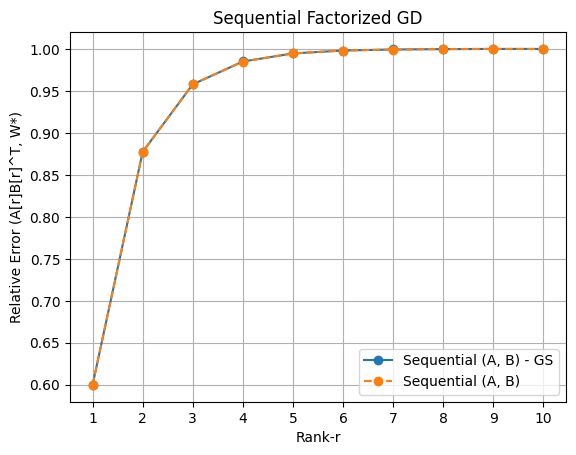

In [116]:
# Visualize relative error for Rank-1 components
plt.plot(
    range(1, args.r + 1),
    [err["rel_error_W"][-1] for err in seq_errors_orth],
    marker="o",
    label="Sequential (A, B) - GS",
)
plt.plot(
    range(1, args.r + 1),
    [err["rel_error_W"][-1] for err in seq_errors],
    marker="o",
    linestyle="--",
    label="Sequential (A, B)",
)
plt.xticks(range(1, args.r + 1))
plt.xlabel("Rank-r")
plt.ylabel("Relative Error (A[r]B[r]^T, W*)")
plt.title("Sequential Factorized GD")
plt.legend()
plt.grid()

plt.show()

Rank 01 - Relative Error (A[:01]B[:01]^T, W*) : 0.5998059205520018
Rank 02 - Relative Error (A[:02]B[:02]^T, W*) : 0.9474260408454769
Rank 03 - Relative Error (A[:03]B[:03]^T, W*) : 1.242285372023599
Rank 04 - Relative Error (A[:04]B[:04]^T, W*) : 1.4206103668021461
Rank 05 - Relative Error (A[:05]B[:05]^T, W*) : 1.5351873280598836
Rank 06 - Relative Error (A[:06]B[:06]^T, W*) : 1.5842995829163924
Rank 07 - Relative Error (A[:07]B[:07]^T, W*) : 1.630454031782165
Rank 08 - Relative Error (A[:08]B[:08]^T, W*) : 1.6580554742966866
Rank 09 - Relative Error (A[:09]B[:09]^T, W*) : 1.6707304328625137
Rank 10 - Relative Error (A[:10]B[:10]^T, W*) : 1.6839668996904908
Rank 01 - Relative Error [Gram-Schmidt Orth] (A[:01]B[:01]^T, W*) : 1.0341110533397355
Rank 02 - Relative Error [Gram-Schmidt Orth] (A[:02]B[:02]^T, W*) : 2.5878529607945433
Rank 03 - Relative Error [Gram-Schmidt Orth] (A[:03]B[:03]^T, W*) : 4.104133325128144
Rank 04 - Relative Error [Gram-Schmidt Orth] (A[:04]B[:04]^T, W*) : 1.76

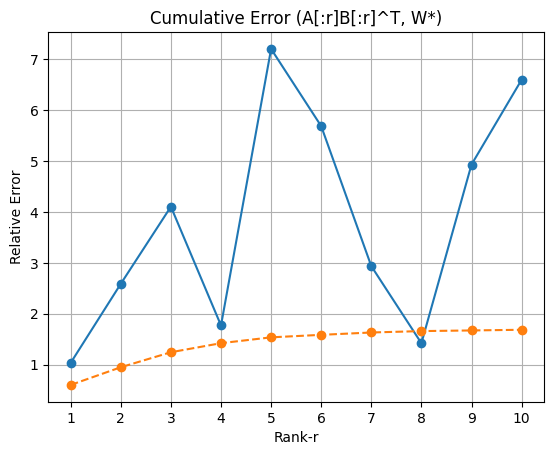

In [117]:
# Cumulative error of rank-r approximation using Sequential Factorized GD
seq_r_errors = np.zeros(args.r)
seq_r_errors_orth = np.zeros(args.r)

for i in range(args.r):
    A_r = np.sum(A_r1s[: i + 1], axis=0)
    B_r = np.sum(B_r1s[: i + 1], axis=0)
    W_r = A_r @ B_r.T
    seq_r_errors[i] = la.norm(W_r - W_star, ord="fro") / la.norm(W_star, ord="fro")
    print(
        f"Rank {i+1:02d} - Relative Error (A[:{i+1:02d}]B[:{i+1:02d}]^T, W*) : {seq_r_errors[i]}"
    )

for i in range(args.r):
    A_r = np.sum(A_r1s_orth[: i + 1], axis=0)
    B_r = np.sum(B_r1s_orth[: i + 1], axis=0)
    W_r = A_r @ B_r.T
    seq_r_errors_orth[i] = la.norm(W_r - W_star, ord="fro") / la.norm(W_star, ord="fro")
    print(
        f"Rank {i+1:02d} - Relative Error [Gram-Schmidt Orth] (A[:{i+1:02d}]B[:{i+1:02d}]^T, W*) : {seq_r_errors_orth[i]}"
    )


# Plotting the Cumulative error of rank-r approximation
plt.plot(
    range(1, args.r + 1), seq_r_errors_orth, marker="o", label="Sequential (A, B) - GS"
)
plt.plot(
    range(1, args.r + 1),
    seq_r_errors,
    marker="o",
    label="Sequential (A, B)",
    linestyle="--",
)
plt.xticks(range(1, args.r + 1))
plt.xlabel("Rank-r")
plt.ylabel("Relative Error")
plt.title("Cumulative Error (A[:r]B[:r]^T, W*)")
plt.grid()

plt.show()

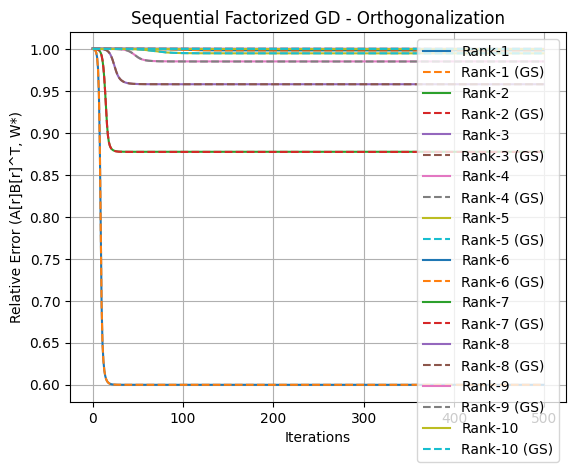

In [118]:
# Visualizing relative errors for the rank-1 components
for i in range(args.r):
    plt.plot(seq_errors_orth[i]["rel_error_W"], label=f"Rank-{i+1}")
    plt.plot(seq_errors[i]["rel_error_W"], label=f"Rank-{i+1} (GS)", linestyle="--")
plt.xlabel("Iterations")
plt.ylabel("Relative Error (A[r]B[r]^T, W*)")
plt.title("Sequential Factorized GD - Orthogonalization")
plt.legend()
plt.grid()
plt.show()

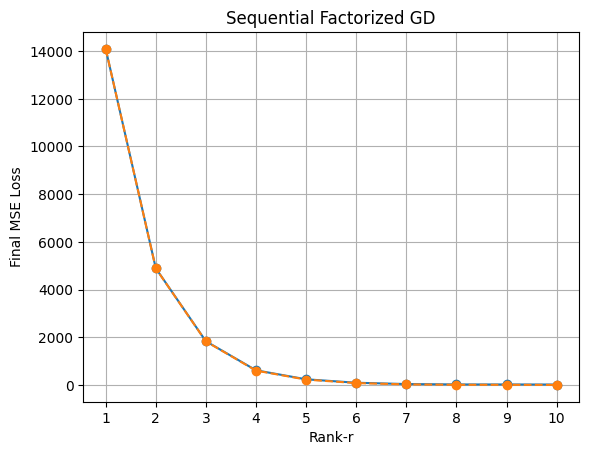

In [120]:
# Plotting the MSE loss for Rank-1 components
plt.plot(
    range(1, args.r + 1),
    [err["mse"][-1] for err in seq_errors_orth],
    marker="o",
    label="Sequential (A, B) - GS",
)
plt.plot(
    range(1, args.r + 1),
    [err["mse"][-1] for err in seq_errors],
    marker="o",
    label="Sequential (A, B)",
    linestyle="--",
)
plt.xticks(range(1, args.r + 1))
plt.xlabel("Rank-r")
plt.ylabel("Final MSE Loss")
plt.title("Sequential Factorized GD")
plt.grid()

plt.show()

## Rough Work

In [73]:
Q, R = la.qr(W_star)
print("Q @ Q^T: \n", np.round(Q @ Q.T))

print("==================================================================")

mag = la.norm(W_star, ord=2, axis=0, keepdims=True)**2 / W_star.shape[0]
Q_ = Q * mag
print("Q_ @ Q_^T: \n", np.round(Q_ @ Q_.T))

Q @ Q^T: 
 [[ 1.  0. -0. ...  0. -0. -0.]
 [ 0.  1.  0. ... -0.  0.  0.]
 [-0.  0.  1. ...  0. -0. -0.]
 ...
 [ 0. -0.  0. ...  0.  0. -0.]
 [-0.  0. -0. ...  0.  1. -0.]
 [-0.  0. -0. ... -0. -0.  1.]]
Q_ @ Q_^T: 
 [[11.  3. -1. ...  0.  0.  0.]
 [ 3. 13.  4. ...  1.  1. -1.]
 [-1.  4.  9. ...  0. -6. -2.]
 ...
 [ 0.  1.  0. ...  6.  5. -2.]
 [ 0.  1. -6. ...  5. 56.  3.]
 [ 0. -1. -2. ... -2.  3.  7.]]
